# Chapter 5
Monte Carlo methods - Blackjack examples

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import math

In [61]:
from collections import defaultdict

In [453]:
class Blackjack_env:
    """
    env will be an interface with the following methods:
    start: return a starting state - (dealer first card, sum of player hand, usable ace)
    act: takes in an action and return next_state, reward, is_end
    it should also have a class variable for actions allowed
    """
    actions = ['h', 's']
    
    def draw_card(self, number_of_cards=1):
        cards = []
        for i in range(number_of_cards):
            card = np.random.randint(2, 15) # 11 is ace, 12, 13, 14 is j, q, k
            if card > 11:
                card = 10
            cards.append(card)
        if number_of_cards == 1:
            return cards[0]
        else:
            return cards
    
    def evaluate_hand(self, cards):
        value = sum(cards)
        if value > 21:
            num_of_ace = sum([card == 11 for card in cards])
            for i in range(num_of_ace):
                value -= 10
                if value <= 21:
                    break
        return value
    
    def has_usable_ace(self, cards):
        if not 11 in cards:
            return False
        value = sum(cards)
        if value > 21:
            num_of_ace = sum([card == 11 for card in cards])
            for i in range(num_of_ace):
                value -= 10
                if value <= 21:
                    ace_left = num_of_ace - i - 1
                    return ace_left > 0
            return False
        else:
            return True
    
    def get_state(self):
        return self.dealer[0], self.evaluate_hand(self.player), self.has_usable_ace(self.player)
    
    def start(self):
        #player = 21
        #dealer = 21
        #while player == 21 or dealer == 21:
        self.dealer = self.draw_card(number_of_cards=2)
        self.player = self.draw_card(number_of_cards=2)
        #    player = self.evaluate_hand(self.player)
        #    dealer = self.evaluate_hand(self.dealer)
        return self.get_state()
    
    def dealer_act(self):
        while(self.evaluate_hand(self.dealer) < 17):
            self.dealer = np.append(self.dealer, values=self.draw_card(number_of_cards=1))

    def act(self, action):

        if len(self.player) == 2 and len(self.dealer) == 2:
            # start
            dealer_hand = self.evaluate_hand(self.dealer)
            player_hand = self.evaluate_hand(self.player)
            if dealer_hand == 21 and player_hand == 21:
                return self.get_state(), 0, True
            elif dealer_hand == 21:
                return self.get_state(), -1, True
            elif player_hand == 21:
                return self.get_state(), 1, True

        if action == 'h':
            self.player = np.append(self.player, values=self.draw_card(number_of_cards=1))
            if self.evaluate_hand(self.player) > 21:
                return self.get_state(), -1, True
            else:
                return self.get_state(), 0, False
        elif action == 's':
            self.dealer_act()
            dealer_hand = self.evaluate_hand(self.dealer)
            player_hand = self.evaluate_hand(self.player)
            if dealer_hand > 21:
                return self.get_state(), 1, True
            elif dealer_hand == player_hand:
                return self.get_state(), 0, True
            elif dealer_hand > player_hand:
                return self.get_state(), -1, True
            else:
                return self.get_state(), 1, True
        else:
            raise("Invalid action")
    
        

## Example 5.1, blackjack monte carlo policy evaluation

In [455]:
class MCAgent:
    def __init__(self, env, policy, discount=1):
        self.env = env
        self.policy = policy
        self.actions = env.actions
        self.V = defaultdict(int)
        self.returns = defaultdict(list)
        self.discount = discount
    
    def evaluate(self, episodes):
        for i in range(episodes):
            G = {}
            step_since_visit = {}
            state = env.start()
            is_end = False
            while not is_end:
                action = self.policy(state)
                next_state, reward, is_end = self.env.act(action)
                if not state in G:
                    G[state] = 0
                    step_since_visit[state] = -1
                for key in G.keys():
                    step_since_visit[key] += 1
                    G[key] += (self.discount ** step_since_visit[key]) * reward
                #if is_end and state[0] == 10 and state[1] == 21 and reward == 0:
                #    print(env.dealer, env.player, state)
                state = next_state
            for state, g in G.items():
                self.returns[state].append(g)
        for state in self.returns.keys():
            self.V[state] = np.mean(self.returns[state])
                

In [607]:
from mpl_toolkits.mplot3d import Axes3D  
from mpl_toolkits.mplot3d import proj3d

"""                                                                                                                                                    
Scaling is done from here...                                                                                                                           
"""
x_scale=1
y_scale=1
z_scale=0.4

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj(ax):
    return lambda : np.dot(Axes3D.get_proj(ax), scale)
    # return np.dot(Axes3D.get_proj(ax), scale)

def plot_value_function(V, no_of_iterations):
    X, Y = np.meshgrid(range(1, 11), range(12, 22)) # X is dealer, Y is player sum
    zs_no = []
    zs_yes = []
    for x,y in zip(np.ravel(X), np.ravel(Y)):
        dealer = 11 if x == 1 else x
        zs_no.append(V[(dealer, y, False)])
        zs_yes.append(V[(dealer, y, True)])
    Z_no = np.array(zs_no).reshape(X.shape)
    Z_yes = np.array(zs_yes).reshape(X.shape)
    
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(121, projection='3d')
    ax.get_proj=short_proj(ax)
    ax.plot_wireframe(X, Y, Z_yes)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('Value')
    ax.set_zticks([-1, 1])
    ax.set_title('Usable ace, %d episodes' %no_of_iterations)
    ax.set_xticklabels(['A', 2, 3, 4, 5, 6, 7, 8, 9, 10])
    
    ax = fig.add_subplot(122, projection='3d')
    ax.get_proj=short_proj(ax)
    ax.plot_wireframe(X, Y, Z_no)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('Value')
    ax.set_zticks([-1, 1])
    ax.set_title('Unusable ace, %d episodes' %no_of_iterations)
    ax.set_xticklabels(['A', 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.show()

In [454]:
env = Blackjack_env()

In [603]:
bj_agent = MCAgent(env, lambda state: 'h' if state[1] < 20 else 's')

In [604]:
bj_agent.evaluate(10000)

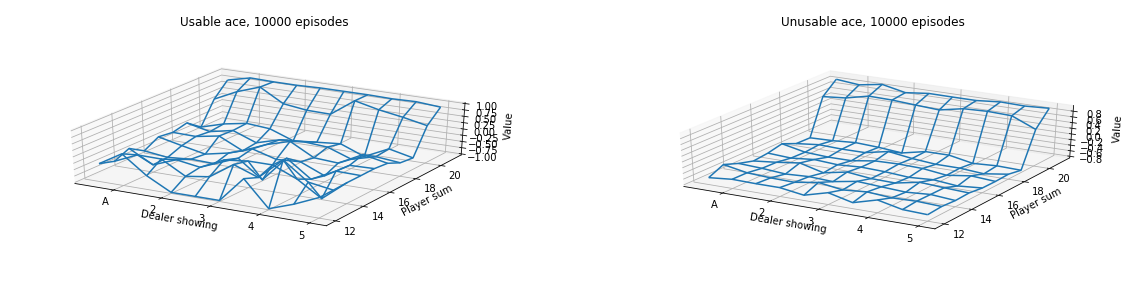

In [605]:
plot_value_function(bj_agent.V, 10000)

In [606]:
bj_agent.evaluate(500000-10000) # to complete 500,000 episodes

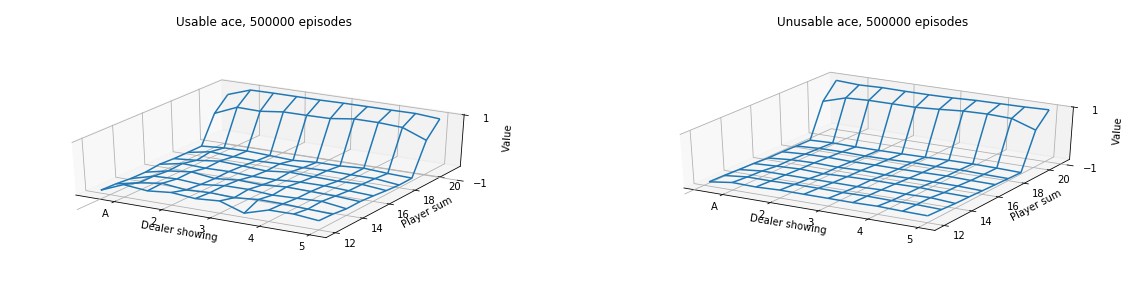

In [608]:
plot_value_function(bj_agent.V, 500000)

## Example 5.3, Monte carlo control with exploring start

In [515]:
class MCESAgent:
    def __init__(self, env, policy=None, discount=1):
        self.env = env
        self.actions = env.actions
        if policy:
            self.policy = policy
        else:
            self.policy = defaultdict(lambda : self.actions[0])
        self.Q = defaultdict(int)
        self.returns = defaultdict(list)
        self.discount = discount
    
    def train(self, episodes):
        for i in range(episodes):
            G = {}
            step_since_visit = {}
            state = env.start()
            action = np.random.choice(self.actions)
            is_end = False
            while not is_end:
                next_state, reward, is_end = self.env.act(action)
                if not (state, action) in G:
                    G[state, action] = 0
                    step_since_visit[state, action] = -1
                for key in G.keys():
                    step_since_visit[key] += 1
                    G[key] += (self.discount ** step_since_visit[key]) * reward
                state = next_state
                action = self.policy[state]
            for key, g in G.items():
                self.returns[key].append(g)
                self.Q[key] = np.mean(self.returns[key])
            for state, _ in G.keys():
                best_value = -1000
                best_action = None
                for action in self.actions:
                    value = self.Q[state, action]
                    if value > best_value:
                        best_value = value
                        best_action = action
                self.policy[state] = best_action
                    

In [516]:
bj_mces_agent = MCESAgent(env, policy=defaultdict(lambda state: 'h' if state[1] < 20 else 's'))

In [517]:
bj_mces_agent.train(5000000)

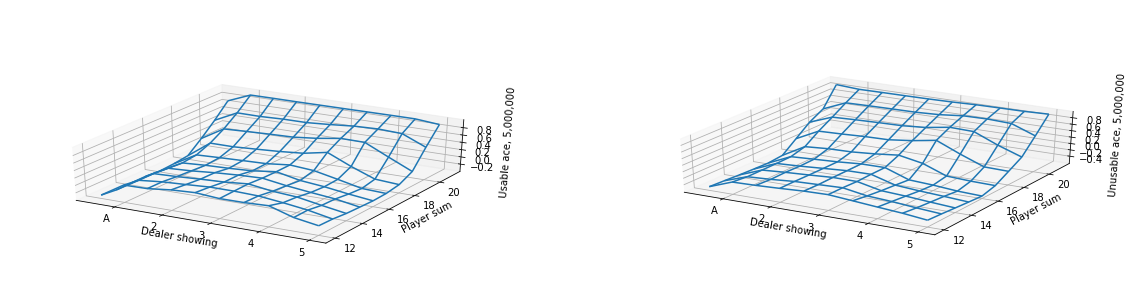

In [589]:
def plot_value_from_q(Q, policy):
    X, Y = np.meshgrid(range(1, 11), range(12, 22)) # X is dealer, Y is player sum
    zs_no = []
    zs_yes = []
    for x,y in zip(np.ravel(X), np.ravel(Y)):
        dealer = 11 if x == 1 else x
        zs_no.append(Q[(dealer, y, False), policy[(dealer, y, False)]])
        zs_yes.append(Q[(dealer, y, True), policy[(dealer, y, True)]])
    Z_no = np.array(zs_no).reshape(X.shape)
    Z_yes = np.array(zs_yes).reshape(X.shape)

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(121, projection='3d')
    ax.get_proj=short_proj(ax)
    ax.plot_wireframe(X, Y, Z_yes)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('Usable ace, 5,000,000')
    ax.set_xticklabels(['A', 2, 3, 4, 5, 6, 7, 8, 9, 10])

    ax = fig.add_subplot(122, projection='3d')
    ax.get_proj=short_proj(ax)
    ax.plot_wireframe(X, Y, Z_no)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel('Unusable ace, 5,000,000')
    ax.set_xticklabels(['A', 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.show()
    
plot_value_from_q(bj_mces_agent.Q, bj_mces_agent.policy)

In [564]:
def plot_policy(policy):
    X, Y = np.meshgrid(np.linspace(1, 10, 100), np.linspace(11, 21, 100)) # X is dealer, Y is player sum
    zs_no = []
    zs_yes = []
    for x,y in zip(np.ravel(X), np.ravel(Y)):
        x = int(math.floor(x))
        y = int(math.floor(y))
        dealer = 11 if x == 1 else x
        zs_no.append(0 if bj_mces_agent.policy[(dealer, y, False)] == 'h' else 1)
        zs_yes.append(0 if bj_mces_agent.policy[(dealer, y, True)] == 'h' else 1)
    Z_no = np.array(zs_no).reshape(X.shape)
    Z_yes = np.array(zs_yes).reshape(X.shape)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    plot = ax.contourf(X, Y, Z_yes)

    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    plt.title('Usable ace, 5,000,000')
    ax.set_xticklabels(['A', 2, 3, 4, 5, 6, 7, 8, 9, 10])
    ax.text(5, 19.5, 'Stick', fontsize=15)
    ax.text(5, 14, 'Hit', color='white', fontsize=15)

    ax = fig.add_subplot(122)
    ax.contourf(X, Y, Z_no)

    ax.set_xlabel('Dealer showing')
    ax.set_ylim(11, 21)
    ax.set_ylabel('Player sum')
    plt.title('Unusable ace, 5,000,000')
    ax.text(5, 19.5, 'Stick', fontsize=15)
    ax.text(8, 14, 'Hit', color='white', fontsize=15)
    ax.set_xticklabels(['A', 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.show()

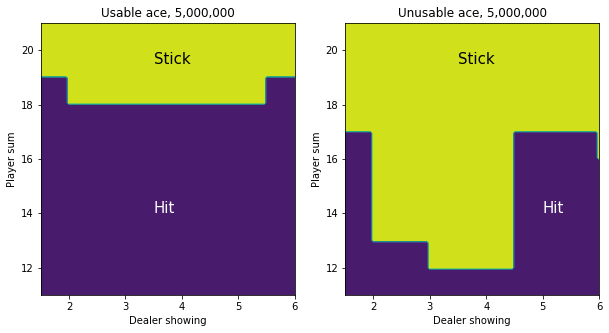

In [565]:
plot_policy(bj_mces_agent.policy)